# Game Data Analysis

In this project, we will use a dataframe with historical data on game sales to identify patterns that determine whether a game will succeed or not. This study will allow us to identify bigger titles ahead of time and help to plan our ad campaigns (using company money the smart way). After we analyze the data for trends, we will apply some hypothesis testing to verify our conclusions.

In [1]:
import pandas as pd

game_data = pd.read_csv('/datasets/games.csv')
display(game_data.info())
game_data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


This dataframe contains 11 features:
- Name: The name of the game
- Platform: The console that the game was released on
- Year_of_Release
- Genre: The game genre
- NA_sales in USD million
- EU_sales in USD million
- JP_sales in USD million
- Other_sales in USD million
- Critic_Score: The overall critics score of the game out of 100
- User_Score: The overall user score of the game out of 10
- Rating: The ESRB game rating

<br>
Of these 11, six are float columns, and the other five are objects (strings). It appears as if there are some missing values, and certainly some column type conversions we will need to perform. Now that we've gotten a look at the data, we are ready to begin wrangling it.

## Data Wrangling

First things first, I want to adjust the column names to lowercase.

In [2]:
game_data.rename(columns={
    'Name':'name',
    'Platform':'platform',
    'Year_of_Release':'year_of_release',
    'Genre':'genre',
    'NA_sales':'na_sales',
    'EU_sales':'eu_sales',
    'JP_sales':'jp_sales',
    'Other_sales':'other_sales',
    'Critic_Score':'critic_score',
    'User_Score':'user_score',
    'Rating':'rating'
}, inplace=True);

Now that we've renamed the columns into something easier to work with (we don't want to accidentally miss a capital!) we can dig deeper into this for missing values and duplicate rows. From the .info method above, we can already see some features with missing values.

### Missing Values

In [3]:
def missing_values_table(df):
    """
    Calculates the total number of missing values and the percentage missing for each column in a dataframe.
    """
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(2)
    print ("This dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
    return mis_val_table_ren_columns

missing_values_table(game_data)

This dataframe has 11 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
critic_score,8578,51.32
rating,6766,40.48
user_score,6701,40.09
year_of_release,269,1.61
name,2,0.01
genre,2,0.01


Ok, looks like we have two missing values in the 'name' and 'genre' column, 269 or roughly 1.6 percent of the data missing in year_of_release, and a substantial number of missing values in the critic/user score and ESRB rating columns. Due to the significantly small number of missing values in name, year, and genre, we are best off removing those from the dataframe. We will need to look deeper into the missing scores and ratings, so let's get rid of the other missing values before continuing.

In [4]:
game_data = game_data.dropna(subset=['name', 'year_of_release', 'genre'])

# verify
missing_values_table(game_data)

This dataframe has 11 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
critic_score,8461,51.45
rating,6676,40.60
user_score,6605,40.17


Great - we dropped the nulls from our three columns and also seemed to remove some nulls from the score/rating columns. Now we need to dig into the missing scores and ratings. My first thought is that these missing values may be due to the age of the game. Research shows that ESRB ratings began in 1994 - so it would make sense for any game released earlier than that to not have an ESRB rating. I'm thinking that user and critic scores may not have been as much of a thing for earlier games as well. Game consoles were expensive and perhaps not as popular as they are now - where gaming is accessible to anyone with internet access and surrounded by popular media, e-sports, and convention crowds. Let's examine to see if this assumption is correct.

In [5]:
pd.pivot_table(
    game_data,
    index='year_of_release',
    values=['critic_score', 'user_score', 'rating'],
    aggfunc=lambda x: x.isnull().sum()
)

,critic_score,rating,user_score
year_of_release,,,
1980.0,9.0,9,9
1981.0,46.0,46,46
1982.0,36.0,36,36
1983.0,17.0,17,17
1984.0,14.0,14,14
1985.0,13.0,13,13
1986.0,21.0,21,21
1987.0,16.0,16,16
1988.0,14.0,14,14


This assumption appears to be very incorrect. There are certainly some missing scores and ratings prior to 1994, but the amount of missing values increases substantially, reaching a peak in 2009/2010 with 775 missing critic scores, 457 missing user scores, and 456 missing ESRB ratings! The advent of the rating system has no impact on these missing scores. The only pattern we can see above is that when one value is missing (score or rating) the other two are also most likely missing. Perhaps these games were indie and/or relatively unpopular. I would suspect that an indie game (independently developed) may not have an ESRB rating as the ratings are not mandatory. An indie game may not receive many public reviews, and may therefore be lacking in "scores" to average into the two score columns. Either this, or simply an incomplete data set. Because the reason for these missing values is unclear, and the amount of missing values is too large to remove, it may be best to simply fill these null values with zeros or "unknown" for the rating.

In [6]:
game_data.fillna({'critic_score' : 0,
                  'user_score' : 0,
                  'rating' : 'unknown'},
                  inplace=True)

# verify
missing_values_table(game_data)

This dataframe has 11 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Excellent - now our missing values are taken care of. It's time to fix our data types and check for any duplicate rows.

### Duplicates and Data Type Conversions

In [7]:
game_data.duplicated().sum()

0

No duplicates!

In [8]:
# user score is object column - why?
game_data['user_score'].unique()

array(['8', 0, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Ahh - it appears as though there is a non-numerical user_score: TBD (to be determined). I imagine this is for games that were very new or not released at the time of this dataframe's creation. Since the game technically has no user score, it may not be entirely incorrect to set it to zero. Let's look and see how many TBDs we are dealing with.

In [9]:
display(game_data.query('user_score == "tbd"').count())
game_data.query('user_score == "tbd"').count() / len(game_data) * 100

name               2376
platform           2376
year_of_release    2376
genre              2376
na_sales           2376
eu_sales           2376
jp_sales           2376
other_sales        2376
critic_score       2376
user_score         2376
rating             2376
dtype: int64

name               14.449039
platform           14.449039
year_of_release    14.449039
genre              14.449039
na_sales           14.449039
eu_sales           14.449039
jp_sales           14.449039
other_sales        14.449039
critic_score       14.449039
user_score         14.449039
rating             14.449039
dtype: float64

In [10]:
tbd_scores = game_data.query('user_score == "tbd"')
pd.pivot_table(
    tbd_scores,
    index='year_of_release',
    values='user_score',
    aggfunc='count'
)

,user_score
year_of_release,
1997.0,1
1999.0,8
2000.0,43
2001.0,82
2002.0,192
2003.0,95
2004.0,107
2005.0,121
2006.0,124


There are certainly a lot of TBD user_scores, and they are certainly not all for recent games. They appear to peak in 2009, oddly enough also when we have the most missing data. Given the amount and spread of this value, it is questionable for us to replace it with 0. With that said, I think this is the best way for us to deal with it given the circumstances. Were I able to communicate directly with the data aggregator, I could make a more informed decision. Let's replace our TBD with 0 and finish converting our data types.

In [11]:
game_data['user_score'].replace('tbd', 0, inplace=True)

In [12]:
game_data['year_of_release'] = game_data['year_of_release'].astype('int32')
game_data['na_sales'] = game_data['na_sales'].astype('float32')
game_data['eu_sales'] = game_data['eu_sales'].astype('float32')
game_data['jp_sales'] = game_data['jp_sales'].astype('float32')
game_data['other_sales'] = game_data['other_sales'].astype('float32')
game_data['critic_score'] = game_data['critic_score'].astype('float32')
game_data['user_score'] = game_data['user_score'].astype('float32')

# verify
game_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int32
genre              16444 non-null object
na_sales           16444 non-null float32
eu_sales           16444 non-null float32
jp_sales           16444 non-null float32
other_sales        16444 non-null float32
critic_score       16444 non-null float32
user_score         16444 non-null float32
rating             16444 non-null object
dtypes: float32(6), int32(1), object(4)
memory usage: 1.7+ MB


Our datatypes have now been optimized - none of the values are too large so we are safe to use 32bit floats and integers instead of 64bit. The year was switched to an integer, and the rest down-scaled to 32bit floats. The last aspect we need to examine are the unique values in our object columns. We need to make sure the values make sense and that there are no misspellings. I will check platform, genre, and rating, as I imagine the names are almost all unique. 

In [13]:
sorted(game_data['platform'].unique())

['2600',
 '3DO',
 '3DS',
 'DC',
 'DS',
 'GB',
 'GBA',
 'GC',
 'GEN',
 'GG',
 'N64',
 'NES',
 'NG',
 'PC',
 'PCFX',
 'PS',
 'PS2',
 'PS3',
 'PS4',
 'PSP',
 'PSV',
 'SAT',
 'SCD',
 'SNES',
 'TG16',
 'WS',
 'Wii',
 'WiiU',
 'X360',
 'XB',
 'XOne']

In [14]:
sorted(game_data['genre'].unique())

['Action',
 'Adventure',
 'Fighting',
 'Misc',
 'Platform',
 'Puzzle',
 'Racing',
 'Role-Playing',
 'Shooter',
 'Simulation',
 'Sports',
 'Strategy']

In [15]:
sorted(game_data['rating'].unique())

['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'RP', 'T', 'unknown']

Ok, all of these appear to be fine by me. They are all unique, nothing misspelled, and do not appear to be variations of one another. The data is now clean and ready to be analyzed. Let's add one new feature to the dataframe as it is missing and will be helpful down the road: the total number of sales globally.

### Feature Engineering

In [16]:
game_data['total_sales'] = game_data['na_sales'] + game_data['eu_sales'] + game_data['jp_sales'] + game_data['other_sales']

# verify
game_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.360001,28.959999,3.77,8.45,76.0,8.0,E,82.539993
1,Super Mario Bros.,NES,1985,Platform,29.080000,3.580000,6.81,0.77,0.0,0.0,unknown,40.240002
2,Mario Kart Wii,Wii,2008,Racing,15.680000,12.760000,3.79,3.29,82.0,8.3,E,35.520000
3,Wii Sports Resort,Wii,2009,Sports,15.610000,10.930000,3.28,2.95,80.0,8.0,E,32.770000
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.270000,8.890000,10.22,1.00,0.0,0.0,unknown,31.380001


Ok excellent, now to round our floats down to two digits. Certainly not crucial, but we don't need six decimal places. 

In [17]:
pd.options.display.float_format = "{:,.2f}".format

In [18]:
# verify
game_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.00,8.00,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0.00,0.00,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.30,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8.00,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0.00,0.00,unknown,31.38


Now we are ready to analyze this. We should have all of the features we need to determine what makes a game successful, and where our advertisements are best spent (assuming we are forecasting for potential successful games in 2017).

## Data Analysis

Let's begin by looking at how many titles we have for each year.

In [19]:
import matplotlib.pyplot as plt

titles_per_year = pd.pivot_table(
                        game_data,
                        index='year_of_release',
                        values='name',
                        aggfunc='count'
                  )

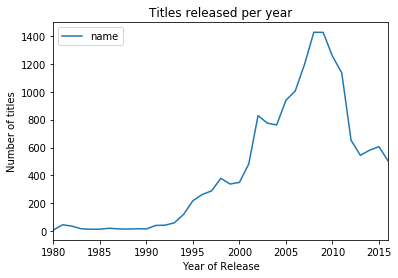

In [20]:
titles_per_year.plot()
plt.xlabel('Year of Release')
plt.ylabel('Number of titles')
plt.title('Titles released per year')
plt.legend();

It looks like most of the titles here were released between 2005 - 2010. It's interesting to note that this is the same time period where we noticed most of the missing values and 'TBD' user scores existed. Remembering that the goal of our analysis is to look for trends to market potential big titles for 2017, we should also consider disregarding some of the older titles. The customer base for video games today is different from the customer base in 1980 and 1990. The features that lead to a success in 1980 will not be the same features that lead to success in 2017. To get the clearest take on what is popular today, we should remove anything prior to 2007. The market in 2017 will most closely resemble the market in the last decade, and since most of our data is in that range we will not lose a lot.
<br><br>
Before we remove the pre-2007 data, let's look at the trends in our platforms.

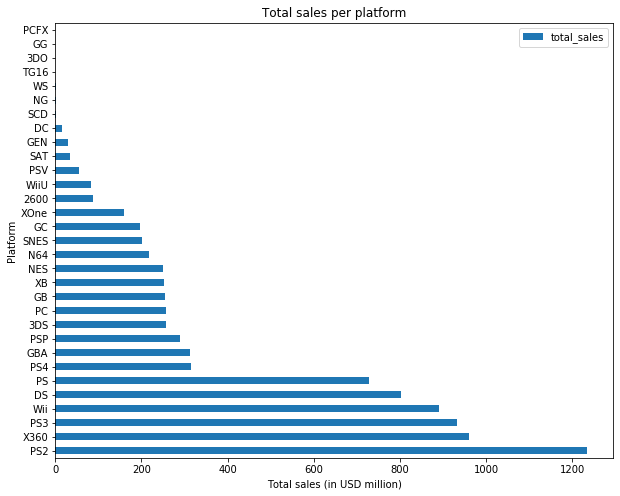

In [21]:
platform_data = game_data.groupby('platform')['total_sales'].sum()

platform_data.sort_values(ascending=False).plot.barh(figsize=(10,8))
plt.xlabel('Total sales (in USD million)')
plt.ylabel('Platform')
plt.title('Total sales per platform')
plt.legend();

It looks like we have a clear winner for total sales: the PS2. The next subset behind it is the original Playstation, Nintendo DS, Nintendo Wii, PS3, and XBox 360. There is a significant drop off in total sales for the next group including the PS4, Gameboy Advance, Playstation Portable, Nintendo 3DS, PC, Gameboy, XBox, Nintendo, Nintendo 64, Super Nintendo, Gamecube, and XBox One. For our purposes, we will focus on just these platforms (from the XBox One to the PS2 ranked by total sales). Let's look a little deeper now and see how long these platforms remain popular by examining the total sales per platform per year.

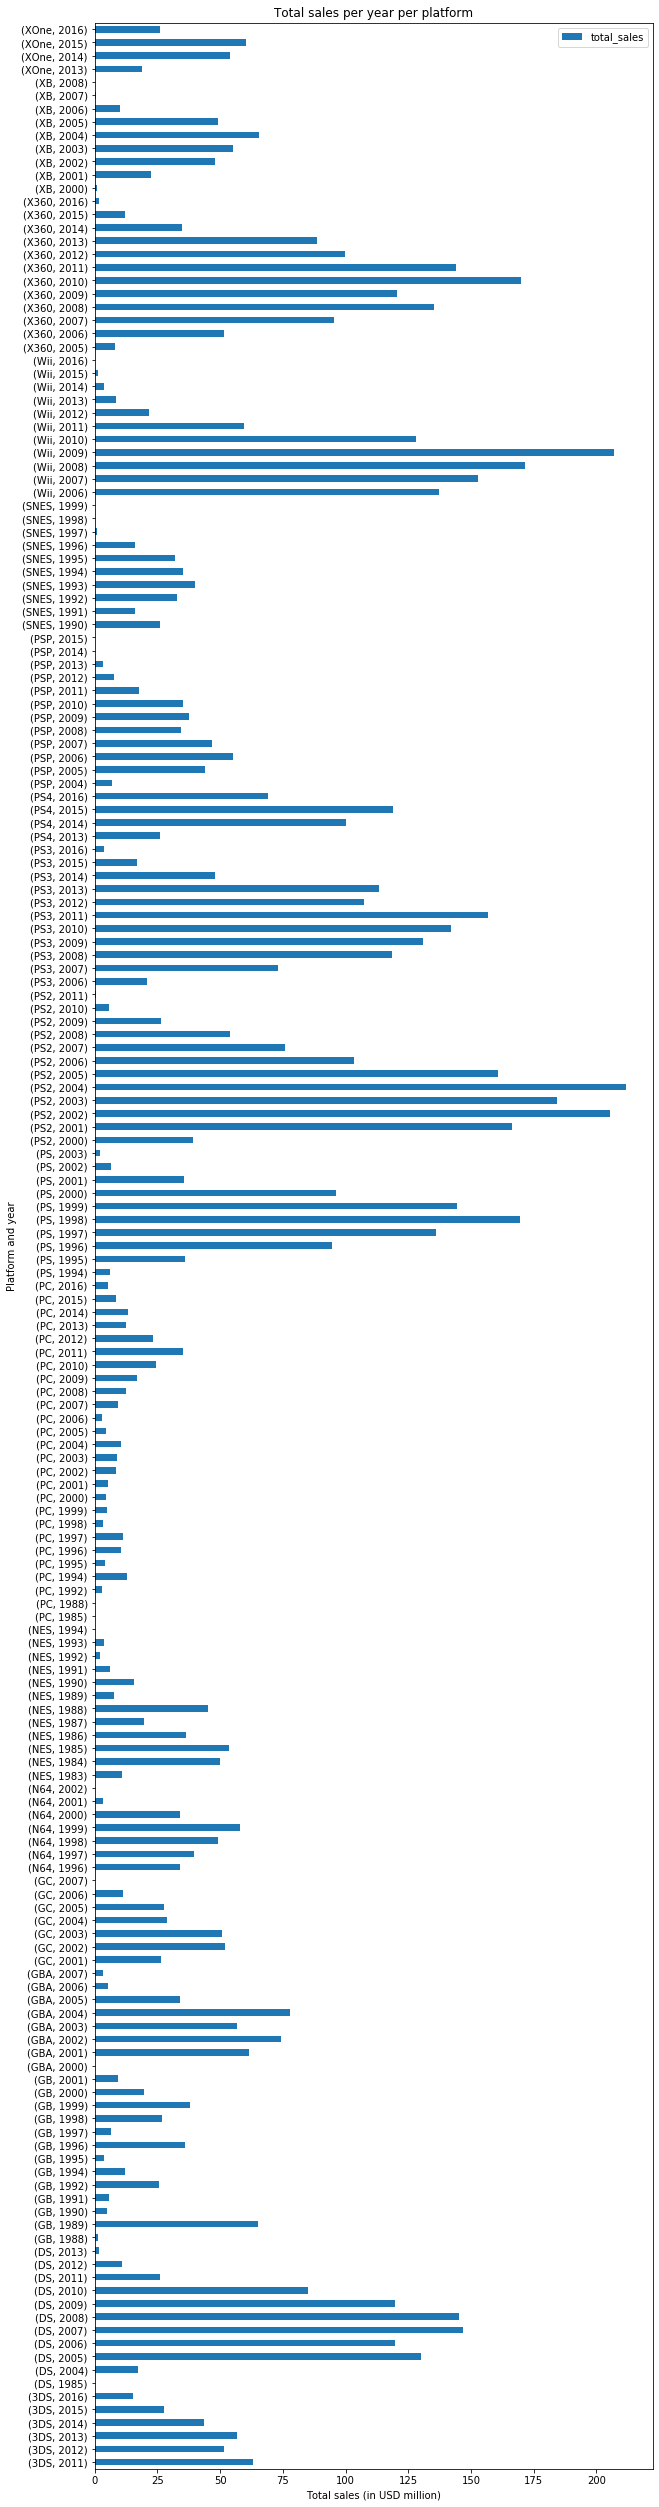

In [22]:
popular_platforms = game_data[game_data['platform'].isin(['PS2', 'X360', 'PS3',
                                                          'Wii', 'DS', 'PS',
                                                          'PS4', 'GBA', 'PSP',
                                                          '3DS', 'PC', 'GB',
                                                          'XB', 'NES', 'N64',
                                                          'SNES', 'GC', 'XOne'
                                                          ])]

platform_sales_per_year = pd.pivot_table(
                                popular_platforms,
                                index=['platform', 'year_of_release'],
                                values='total_sales',
                                aggfunc='sum'
                          )
platform_sales_per_year.plot.barh(figsize=(10,45))
plt.xlabel('Total sales (in USD million)')
plt.ylabel('Platform and year')
plt.title('Total sales per year per platform')
plt.legend();

Each platform appears to remain popular for about 6 years. There are certainly exceptions to this rule, but most of the included platforms here appear to be in a 6 year cycle. The year that a new platform is released, the "older" platform has it's last or second to last year of sales as the "successor" starts to ramp up with new titles. Playstation is a clear exception to this rule, with the PS2 maintaining sales for about 9 years, and overlapping with the PS3 for 4 before fizzling out in 2011. The XBox 360 also maintained great sales for about 10 years, and overlapped with the XBox One for 3-4 years. The current generation platforms like the PS4 and XBox One are still "new" in this dataframe so they also do not stand by this 6 year cycle (each of them are only 4 years old). PC will also be outside of this cycle as PC gaming is an "outlier" as far as other platforms are concerned. In this dataframe, PC sales have remained steady from 1992 to 2016, peaking around 2009 - 2012.
<br><br>
Considering both of the above graphs, I think we are best off considering the most popular platforms from 2005 onwards. This slice of our dataframe will give us the best information on current gaming trends so that we can market the most likely profitable titles in 2017.

In [23]:
game_data = game_data[game_data['year_of_release'] > 2007]

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


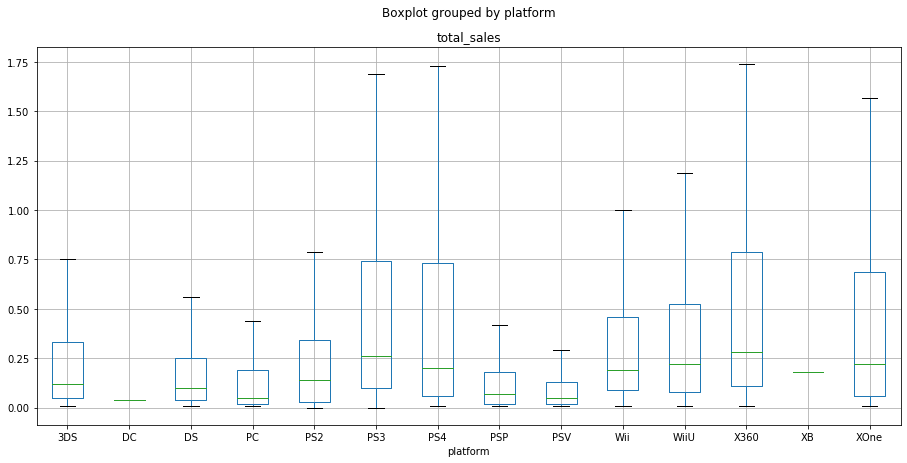

In [24]:
game_data.boxplot(by='platform', column='total_sales', showfliers=False, figsize=(15,7));

From the above, we can see how the total sales vary by platform. Our best selling platforms appear to be the PS3, PS4, X360, and XOne. The older generations of each (PS3 and X360) have a slightly higher median but this may be due to how relatively new the next generation is. Overall, the spread of the best selling platforms seem to put them noticeably apart from the pack. The Wii and WiiU are about on pace with the PS2, and the rest of the platforms have their medians in the 0 - 0.25 range. 

Now let's focus on how much critic and user reviews affect the total sales for titles. Let's look into the PS3 titles to see review impact on sales.

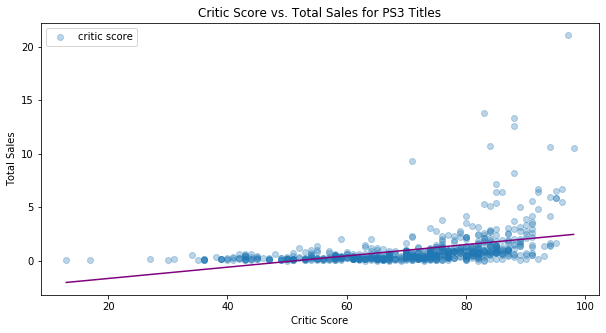

Pearson correlation: 0.4277390112301396


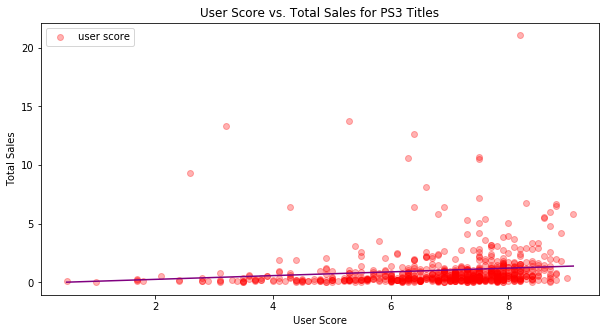

Pearson correlation: 0.12999846331458


In [25]:
import numpy as np

# filter by platform and removing 0 scores
ps3_data = game_data[(game_data['platform'] == 'PS3') &
                     (game_data['critic_score'] != 0) &
                     (game_data['user_score'] != 0)]

# set appropriate fig size first
plt.rcParams["figure.figsize"] = (10,5)

# then create scatter plots
plt.scatter(ps3_data['critic_score'], ps3_data['total_sales'], label='critic score', alpha=0.3)
plt.xlabel('Critic Score')
plt.ylabel('Total Sales')
plt.title('Critic Score vs. Total Sales for PS3 Titles')
# correlation line
plt.plot(np.unique(ps3_data['critic_score']),
         np.poly1d(np.polyfit(ps3_data['critic_score'], ps3_data['total_sales'], 1))
         (np.unique(ps3_data['critic_score'])), color='purple')
plt.legend()
plt.show()
# print correlation
print('Pearson correlation:', ps3_data['critic_score'].corr(ps3_data['total_sales']))

plt.scatter(ps3_data['user_score'], ps3_data['total_sales'], label='user score', color='red', alpha=0.3)
plt.xlabel('User Score')
plt.ylabel('Total Sales')
plt.title('User Score vs. Total Sales for PS3 Titles')
# correlation line
plt.plot(np.unique(ps3_data['user_score']),
         np.poly1d(np.polyfit(ps3_data['user_score'], ps3_data['total_sales'], 1))
         (np.unique(ps3_data['user_score'])), color='purple')
plt.legend()
plt.show()
# print correlation
print('Pearson correlation:', ps3_data['user_score'].corr(ps3_data['total_sales']))

In [26]:
# revert fig size back to normal
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

From the above, we can see that there is a slight positive correlation between the critic and user scores on the total sales of a given title. There appears to be a higher correlation on the side of critic reviews. This is possibly due to customers trusting a professional critic over a user, and/or also the fact that critics often receive the game before users. The critic review will usually be the first review a potential customer sees. If it's a generally positive review, the user is more likely to purchase it. If the game is good, then the user will likely give it a positive review as well - leading to the slight positive correlation on the user_score. Regardless of how it actually happens, scores do appear to have an affect on the total sales of a game.
<br><br>
Now lets look to see how the platform impacts game sales. There are some multi-platform titles in our data set, so let's pull them into a new dataframe and plot the results.

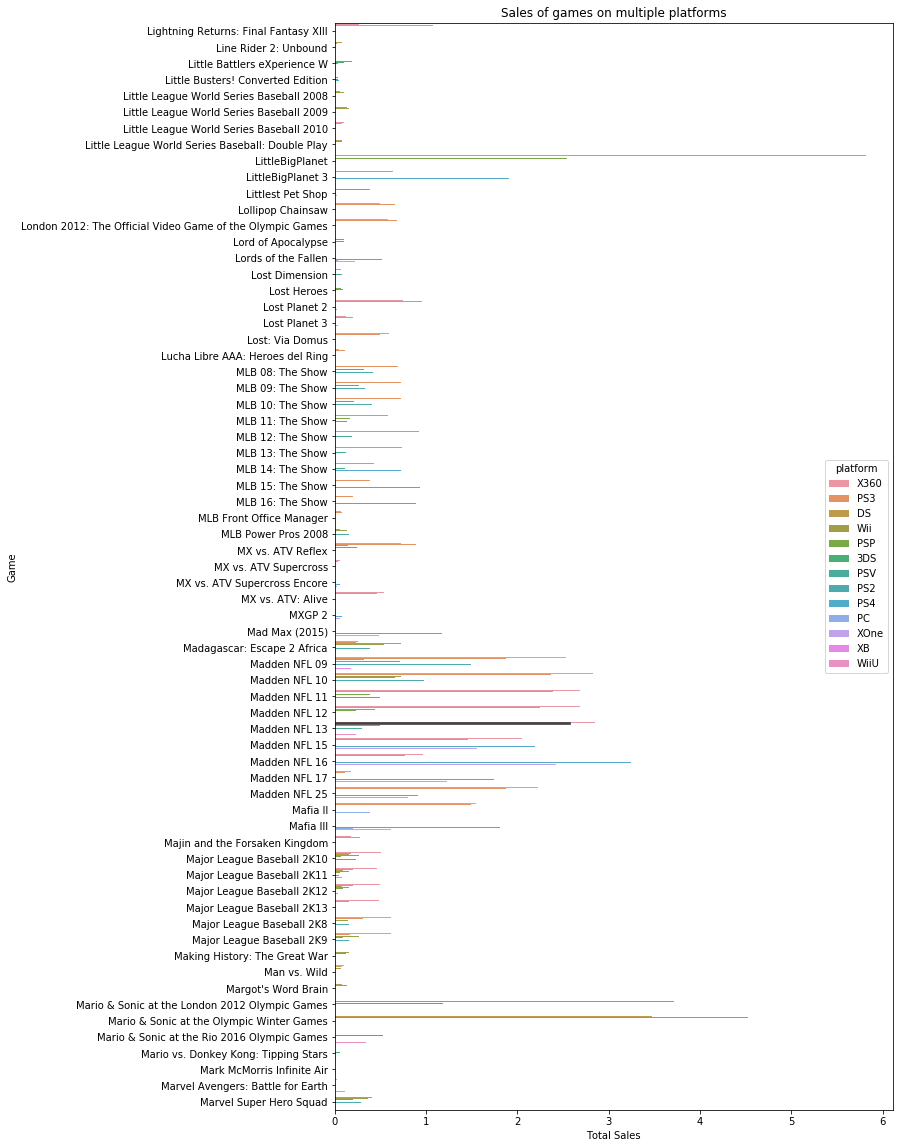

In [27]:
import seaborn as sns

# filter by duplicated titles
same_game_df = game_data[game_data.duplicated(subset='name', keep=False)].sort_values(by='name')

# since this is a large df, let's look at a subset of it
same_game_df_1 = same_game_df[2000:2200]

# set appropriate fig size first
plt.rcParams["figure.figsize"] = (10,20)

sns.barplot(x='total_sales', hue='platform', y='name', data=same_game_df_1, orient='h')
plt.xlabel("Total Sales")
plt.ylabel("Game")
plt.title("Sales of games on multiple platforms")
plt.show()

In [28]:
same_game_df.head(20)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
3358,Frozen: Olaf's Quest,3DS,2013,Platform,0.27,0.27,0.00,0.05,0.00,0.00,unknown,0.59
3862,Frozen: Olaf's Quest,DS,2013,Platform,0.21,0.26,0.00,0.04,0.00,0.00,unknown,0.51
1785,007: Quantum of Solace,PS3,2008,Action,0.43,0.51,0.02,0.19,65.00,6.60,T,1.15
1285,007: Quantum of Solace,X360,2008,Action,0.82,0.51,0.01,0.14,65.00,7.10,T,1.48
4475,007: Quantum of Solace,PS2,2008,Action,0.17,0.00,0.00,0.26,0.00,0.00,unknown,0.43
3120,007: Quantum of Solace,Wii,2008,Action,0.29,0.28,0.01,0.07,54.00,7.50,T,0.65
14658,007: Quantum of Solace,PC,2008,Action,0.01,0.01,0.00,0.00,70.00,6.30,T,0.02
9507,007: Quantum of Solace,DS,2008,Action,0.11,0.01,0.00,0.01,65.00,0.00,T,0.13
15091,11eyes: CrossOver,X360,2009,Adventure,0.00,0.00,0.02,0.00,0.00,0.00,unknown,0.02
15656,11eyes: CrossOver,PSP,2010,Adventure,0.00,0.00,0.02,0.00,0.00,0.00,unknown,0.02


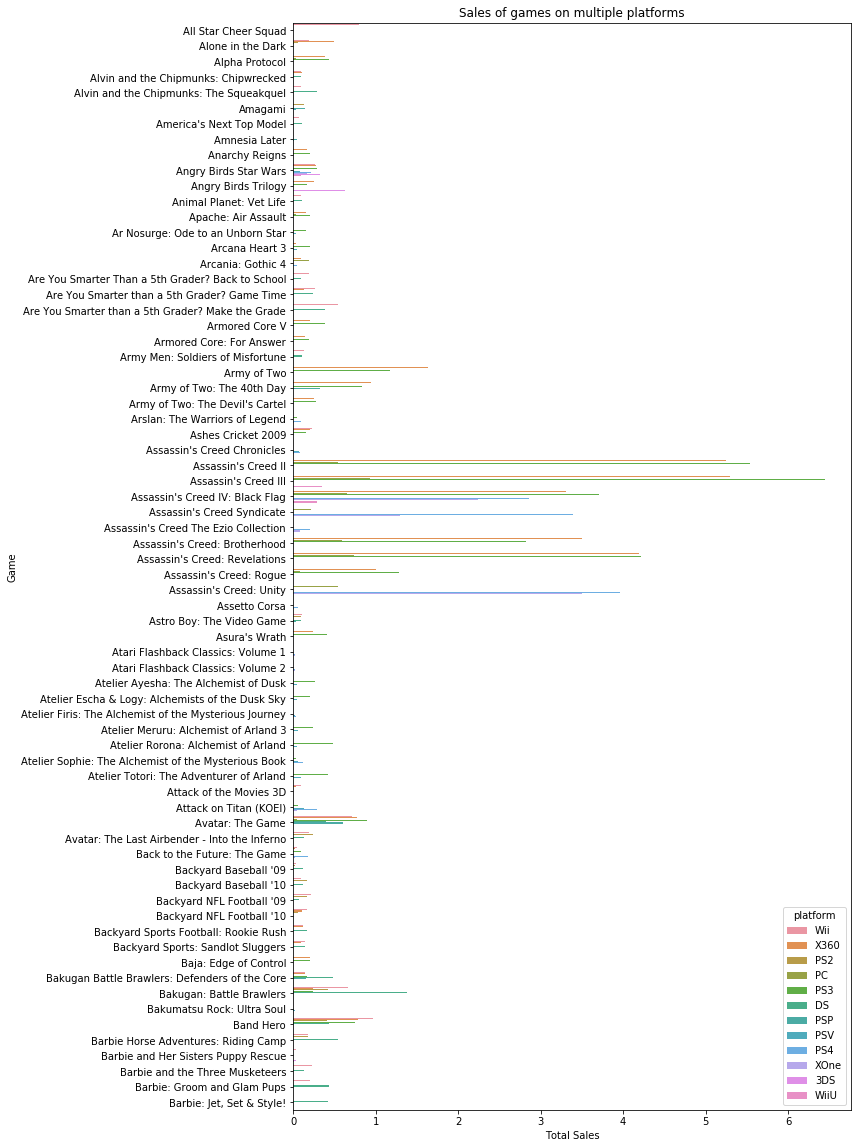

In [29]:
# let's look at the next few hundred as well
same_game_df_2 = same_game_df[100:300]

sns.barplot(x='total_sales', hue='platform', y='name', data=same_game_df_2, orient='h')
plt.xlabel("Total Sales")
plt.ylabel("Game")
plt.title("Sales of games on multiple platforms")
plt.show()

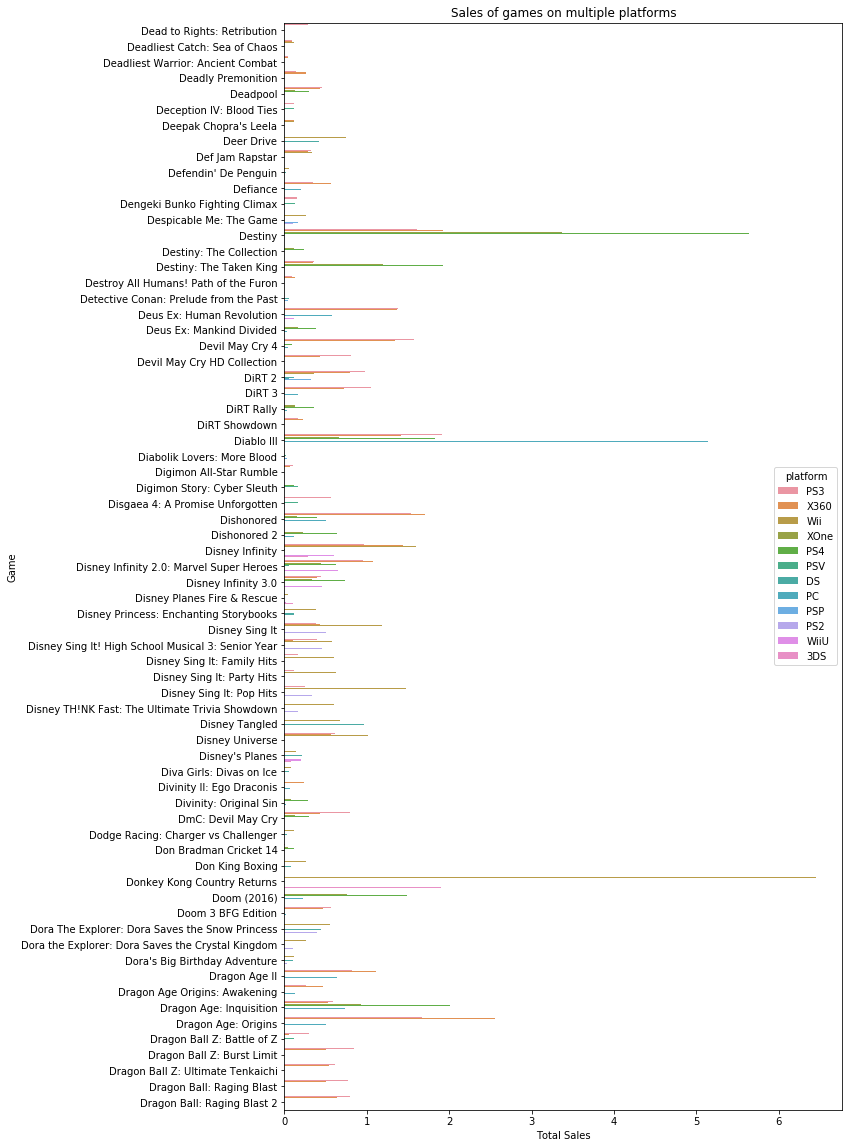

In [30]:
same_game_df_3 = same_game_df[800:1000]

sns.barplot(x='total_sales', hue='platform', y='name', data=same_game_df_3, orient='h')
plt.xlabel("Total Sales")
plt.ylabel("Game")
plt.title("Sales of games on multiple platforms")
plt.show()

From the slices we can see above, there does not appear to be any clear relationship between the platform a game is released on and the total sales. By this I mean, some games appear to do well on XB early on and then later versions appear more popular on PS. Others appear to be popular on both XB and PS equally throughout the lifespan of the series.
<br><br>
Next let's look to see what our best-selling genres are.

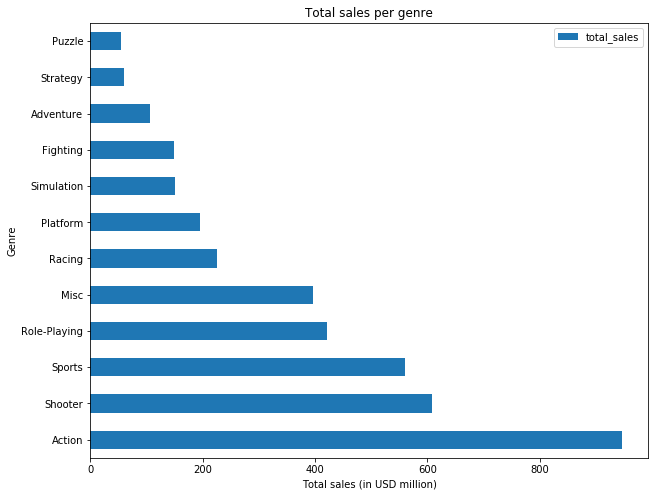

In [31]:
genre_data = game_data.groupby('genre')['total_sales'].sum()

genre_data.sort_values(ascending=False).plot.barh(figsize=(10,8))
plt.xlabel('Total sales (in USD million)')
plt.ylabel('Genre')
plt.title('Total sales per genre')
plt.legend();

Our highest selling game genres are action, sports, and shooter. In my opinion, this slices the largest group of video game customers. Shooters and sports titles are popular in e-sports and are released very regularly (titles like Call of Duty and Fifa). Action covers the rest of the market as it's a fairly general genre that most titles would likely qualify for. On the other end of the spectrum we have our lowest selling genres: strategy, adventure, and puzzle. These genres often move at a slower pace and may require a lot more reading and thinking to progress. These game genres do not lend themselves to competition well and therefore miss the e-sports market, further decreasing potential sales. 

To conclude our EDA - we have found that we should focus on data after 2007, and that our best sellers will be in the action, sports, and shooter genres. There does not appear to be any effect that the platform has on our multi-platform releases, but PS and XBox appear to do the best, so our marketing will focus on the current generation of those manufacturers: PS4 and XOne. 

## Regional User Profiles

Now that we've targeted our decade, platform, and genre, let's see what the regional sales can tell us about what is popular in NA, EU, and JP.

### Popular Platform

In [32]:
game_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.30,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8.00,E,32.77
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.00,8.40,E,28.32
14,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,61.00,6.30,E,21.82
15,Wii Fit Plus,Wii,2009,Sports,9.01,8.49,2.53,1.77,80.00,7.40,E,21.80


In [33]:
pop_platform_reg = pd.pivot_table(
                        game_data,
                        index='platform',
                        values=['na_sales', 'eu_sales', 'jp_sales'],
                        aggfunc='sum'
                   )
# na first
pop_platform_reg.sort_values(by='na_sales', ascending=False).head()

,eu_sales,jp_sales,na_sales
platform,,,
X360,234.88,9.30,490.69
PS3,293.73,74.11,349.13
Wii,170.74,47.01,332.87
DS,86.13,76.12,198.73
PS4,141.09,15.96,108.74


In [34]:
# eu next
pop_platform_reg.sort_values(by='eu_sales', ascending=False).head()

,eu_sales,jp_sales,na_sales
platform,,,
PS3,293.73,74.11,349.13
X360,234.88,9.30,490.69
Wii,170.74,47.01,332.87
PS4,141.09,15.96,108.74
PC,92.17,0.00,41.07


In [35]:
# jp last
pop_platform_reg.sort_values(by='jp_sales', ascending=False).head()

,eu_sales,jp_sales,na_sales
platform,,,
3DS,61.27,100.62,82.65
DS,86.13,76.12,198.73
PS3,293.73,74.11,349.13
PSP,26.21,60.46,34.04
Wii,170.74,47.01,332.87


The top 5 platforms for NA are X360, PS3, Wii, DS, and PS4. This list is almost the same though slightly reordered for the EU - the only difference is that the DS is swapped for PC. JP has the most interesting top 5 where portable gaming platforms seem to be much more popular. The 3DS and DS are the top selling platforms, with the PS3 and Wii also making the list. The PSP makes the top 5 here as well. 
<br><br>
Let's look at the genres next.

### Popular Genre

In [36]:
pop_genre_reg = pd.pivot_table(
                    game_data,
                    index='genre',
                    values=['na_sales', 'eu_sales', 'jp_sales'],
                    aggfunc='sum'
                )
# na first
pop_genre_reg.sort_values(by='na_sales', ascending=False).head()

,eu_sales,jp_sales,na_sales
genre,,,
Action,310.59,90.16,433.74
Shooter,208.35,15.93,311.26
Sports,185.19,30.69,276.27
Misc,107.00,37.33,211.61
Role-Playing,94.46,138.12,155.81


In [37]:
# eu next
pop_genre_reg.sort_values(by='eu_sales', ascending=False).head()

,eu_sales,jp_sales,na_sales
genre,,,
Action,310.59,90.16,433.74
Shooter,208.35,15.93,311.26
Sports,185.19,30.69,276.27
Misc,107.00,37.33,211.61
Role-Playing,94.46,138.12,155.81


In [38]:
# jp last
pop_genre_reg.sort_values(by='jp_sales', ascending=False).head()

,eu_sales,jp_sales,na_sales
genre,,,
Role-Playing,94.46,138.12,155.81
Action,310.59,90.16,433.74
Misc,107.00,37.33,211.61
Sports,185.19,30.69,276.27
Adventure,29.87,23.36,43.52


NA and EU have the exact same breakdown with Action first, then Shooter, Sports, Misc, and Role-Playing. JP is the only region with a different rank though with most of the same genres. It's top 5 are Role-Playing, Action, Misc, Sports, and Adventure taking the fifth spot. 
<br><br>
The last feature I would like to look at here is the effect that the ESRB rating could have on sales per region.

### ESRB Rating

In [39]:
esrb_reg = pd.pivot_table(
                game_data,
                index='rating',
                values=['na_sales', 'eu_sales', 'jp_sales'],
                aggfunc='sum'
           )

# na first
esrb_reg.sort_values(by='na_sales', ascending=False)

,eu_sales,jp_sales,na_sales
rating,,,
E,326.61,77.17,536.93
M,362.65,39.33,502.60
T,187.62,64.51,303.41
E10+,144.53,25.67,251.88
unknown,188.85,220.60,218.51
EC,0.00,0.00,1.32
RP,0.03,0.00,0.00


In [40]:
# eu next
esrb_reg.sort_values(by='eu_sales', ascending=False)

,eu_sales,jp_sales,na_sales
rating,,,
M,362.65,39.33,502.60
E,326.61,77.17,536.93
unknown,188.85,220.60,218.51
T,187.62,64.51,303.41
E10+,144.53,25.67,251.88
RP,0.03,0.00,0.00
EC,0.00,0.00,1.32


In [41]:
# jp last
esrb_reg.sort_values(by='jp_sales', ascending=False)

,eu_sales,jp_sales,na_sales
rating,,,
unknown,188.85,220.60,218.51
E,326.61,77.17,536.93
T,187.62,64.51,303.41
M,362.65,39.33,502.60
E10+,144.53,25.67,251.88
EC,0.00,0.00,1.32
RP,0.03,0.00,0.00


This is the first time that all three regions had the same top 5, albeit in very different orders. E and M receive fairly equivalent sales in all three regions, though the "unknown" rating appears to be the clear winner in JP. "Unknown" does also appear in the NA and EU lists and does similarly well in all three regions. I think we can see that the ESRB rating does appear to impact the sale of a game. It may be best to focus our marketing efforts in games rated E, M, and unknown. 

## Hypothesis Testing

We will start with our null hypothesis: The average user score of the Xbox One and PC platforms are the same. Our alternative hypothesis would then be: The average user score of the Xbox One and PC platforms differ. We will test this by looking at the p-value, set to 0.05 (or 5 percent), and applying a single sample T-test using scipy.

In [42]:
xone_uscore = game_data.groupby('platform')['user_score'].get_group('XOne')
pc_uscore = game_data.groupby('platform')['user_score'].get_group('PC')

print(xone_uscore.mean(), pc_uscore.mean())

4.805263 5.225831


In [43]:
import scipy.stats as st

alpha = 0.05
results = st.ttest_ind(xone_uscore, pc_uscore)

print('pvalue: ', results.pvalue)
print('alpha: ', alpha)
if results.pvalue < alpha:
    print('We reject the null hypothesis')
else:
    print('We cannot reject the null hypothesis')

pvalue:  0.06979802970939326
alpha:  0.05
We cannot reject the null hypothesis


The above test resulted in a pvalue greater than our alpha, meaning we cannot reject the null hypothesis. Therefore, the average user scores for XOne and PC games are the same. The above means seem to lead to this conclusion as well. They are different, with PC having a slightly higher average than XOne, but not by much (less than half of a point on a scale of 1 to 10). 

Next we will test another hypothesis. Our null hypothesis will be: The average user score for the Action and Sports genres are the same. Our alternative hypothesis would then be: The average user score for the Action and Sports genres are different. We will test this by looking at the p-value, set to 0.05 (or 5 percent), and applying a single sample T-test using scipy.

In [44]:
action_uscore = game_data.groupby('genre')['user_score'].get_group('Action')
sports_uscore = game_data.groupby('genre')['user_score'].get_group('Sports')

print(action_uscore.mean(), sports_uscore.mean())

3.723743 3.231211


In [45]:
alpha = 0.05
results = st.ttest_ind(action_uscore, sports_uscore)

print('pvalue: ', results.pvalue)
print('alpha: ', alpha)
if results.pvalue < alpha:
    print('We reject the null hypothesis')
else:
    print('We cannot reject the null hypothesis')

pvalue:  0.0003354374031217955
alpha:  0.05
We reject the null hypothesis


The above test resulted in a pvalue much less than our alpha, meaning we can reject the null hypothesis and accept the alternative: The average user score for the Action and Sports genres are different. We also see this in the mean values above, with Action games ranking higher than Sports. It is interesting to note that the amount is roughly the same as our first hypothesis (roughly half of a point) though the result of the t-test is different.

# Conclusion

From our study of this game data, we were able to learn the most popular features to target our marketing campaigns on future titles. Potential big sellers in 2017 would have these features in common:
- Genre: Action, Sports, Shooter
- Platform: PS4, XOne, PS3, X360, Wii
- ESRB Rating: E, M, unknown
- Higher Critic Score (80+)

If we target games matching these features, we will use our marketing campaign money most effectively. 